# Custom pipeline search spaces

TODO: add details

## Dataset

This demonstration uses the [German Credit](https://www.openml.org/d/31) dataset from OpenML.
The dataset has both categorical features, represented as strings, and
numeric features. 

For illustration purposes, we also add some missing values, represented as `NaN`.

In [1]:
import lale.datasets.openml
import lale.helpers
(train_X, train_y), (test_X, test_y) = \
    lale.datasets.openml.fetch('credit-g', 'classification', preprocess=False)
print(f'train_X.shape {train_X.shape}, train_y.shape {train_y.shape}')

train_X.shape (670, 20), train_y.shape (670,)


In [2]:
train_X = lale.helpers.add_missing_values(train_X, seed=42)
print(f'Small train_X.shape {train_X.shape} train_y.shape {train_y.shape}')

Small train_X.shape (670, 20) train_y.shape (670,)


Printing the last few samples of the training data reveals
`credit_amount=NaN` for sample number 763.

In [3]:
import pandas as pd
pd.options.display.max_columns = None
NROWS = 8
df = pd.concat([train_y.tail(NROWS), train_X.tail(NROWS)], axis=1)
display(df.style.highlight_null('yellow'))

,class,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
359,bad,<0,30.000000,existing paid,furniture/equipment,2406.000000,<100,4<=X<7,4.000000,female div/dep/mar,none,4.000000,real estate,23.000000,none,rent,1.000000,skilled,1.000000,none,yes
707,bad,0<=X<200,12.000000,no credits/all paid,furniture/equipment,2969.000000,<100,<1,4.000000,female div/dep/mar,none,3.000000,life insurance,25.000000,none,rent,2.000000,skilled,1.000000,none,yes
763,bad,no checking,21.000000,critical/other existing credit,new car,nan,no known savings,>=7,4.000000,male single,none,4.000000,no known property,30.000000,none,for free,1.000000,high qualif/self emp/mgmt,1.000000,yes,yes
835,bad,<0,12.000000,no credits/all paid,new car,1082.000000,<100,1<=X<4,4.000000,male single,none,4.000000,car,48.000000,bank,own,2.000000,skilled,1.000000,none,yes
192,bad,0<=X<200,27.000000,existing paid,business,3915.000000,<100,1<=X<4,4.000000,male single,none,2.000000,car,36.000000,none,own,1.000000,skilled,2.000000,yes,yes
629,good,no checking,9.000000,existing paid,education,3832.000000,no known savings,>=7,1.000000,male single,none,4.000000,real estate,64.000000,none,own,1.000000,unskilled resident,1.000000,none,yes
559,bad,0<=X<200,18.000000,critical/other existing credit,furniture/equipment,1928.000000,<100,<1,2.000000,male single,none,2.000000,real estate,31.000000,none,own,2.000000,unskilled resident,1.000000,none,yes
684,good,0<=X<200,36.000000,delayed previously,business,9857.000000,100<=X<500,4<=X<7,1.000000,male single,none,3.000000,life insurance,31.000000,none,own,2.000000,unskilled resident,2.000000,yes,yes


In [4]:
train_y.value_counts()

good    466
bad     204
Name: class, dtype: int64

## Data preprocessing

Given that the dataset has both numerical and categorical columns with missing values, we "project" the data based on types and use:

- One-hot encoding for categorical columns
- Simple imputation for numerical columns

In [5]:
from lale.lib.lale import Project, ConcatFeatures
from lale.lib.sklearn import OneHotEncoder, SimpleImputer
cat_enc = Project(columns={"type": "string"}) >> OneHotEncoder(handle_unknown="ignore")
num = Project(columns={"type": "number"}) >> SimpleImputer()
prefix = (cat_enc & num) >> ConcatFeatures()

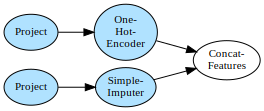

In [6]:
prefix.visualize()

## Lale operators and a custom pipeline

In [7]:
import warnings
warnings.filterwarnings("ignore")
from lale.lib.lale import NoOp
from lale.lib.sklearn import KNeighborsClassifier
from lale.lib.sklearn import LogisticRegression, SVC, MLPClassifier
from lale.lib.sklearn import Nystroem
from lale.lib.sklearn import PCA
from lale.lib.sklearn import StandardScaler
from lale.operators import make_union, make_choice, make_pipeline
import lale.schemas as schemas

### PCA vs Kernel PCA

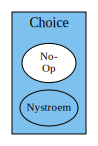

In [8]:
kernel_tfm_or_not =  NoOp | Nystroem
kernel_tfm_or_not.visualize()

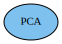

In [9]:
tfm = PCA
tfm.visualize()

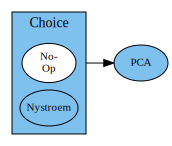

In [10]:
pca_or_kernel_pca = kernel_tfm_or_not >> tfm
pca_or_kernel_pca.visualize()

### Customizing the architectural search space for multi-layered perceptrons

In [11]:
MLPClassifier.hyperparam_schema('hidden_layer_sizes')

{'description': 'The ith element represents the number of neurons in the ith hidden layer.',
 'type': 'array',
 'laleType': 'tuple',
 'minItemsForOptimizer': 1,
 'maxItemsForOptimizer': 20,
 'items': {'type': 'integer',
  'minimumForOptimizer': 1,
  'maximumForOptimizer': 500},
 'default': [100]}

In [12]:
Shallow = MLPClassifier.customize_schema(
    hidden_layer_sizes=schemas.Array(
        minItemsForOptimizer=1,
        maxItemsForOptimizer=2,
        items=schemas.Int(minimumForOptimizer=1, maximumForOptimizer=50),
        default=[10],
        laleType='tuple',
    )
)

In [13]:
Shallow.hyperparam_schema('hidden_layer_sizes')

{'default': [10],
 'type': 'array',
 'items': {'type': 'integer',
  'minimumForOptimizer': 1,
  'maximumForOptimizer': 50},
 'minItemsForOptimizer': 1,
 'maxItemsForOptimizer': 2,
 'laleType': 'tuple'}

### Custom data-prep pipeline

- Preprocess data via one-hot encoding of categorical and simple imputation for numerical columns
- Standard scaling of all features
- Generate features from PCA or Kernel PCA
- Generate predictions from Shallow neural network and use its prediction as new features

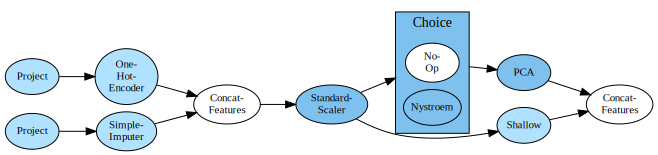

In [14]:
data_prep = (
    prefix >> StandardScaler >>
    (
        pca_or_kernel_pca &
        Shallow(solver='adam')
    ) >> ConcatFeatures()
)
data_prep.visualize()
                                         

### Customizing the range for the number of neighbors in a nearest-neighbor classifier

In [15]:
KNeighborsClassifier.hyperparam_schema('n_neighbors')

{'description': 'Number of neighbors to use by default for kneighbors queries.',
 'type': 'integer',
 'distribution': 'uniform',
 'minimum': 1,
 'laleMaximum': 'X/maxItems',
 'default': 5,
 'maximumForOptimizer': 100}

In [16]:
SmallK = KNeighborsClassifier.customize_schema(
    n_neighbors=schemas.Int(minimum=1, maximum=5, maximumForOptimizer=5)
)
SmallK.hyperparam_schema('n_neighbors')

{'type': 'integer', 'minimum': 1, 'maximum': 5, 'maximumForOptimizer': 5}

### Final predictor/estimator

- L1 penalized logistic regression, OR
- Nearest neighbor classifier with a small number of neighbors

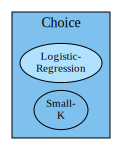

In [17]:
est = LogisticRegression(penalty='l1', solver='liblinear') | SmallK
est.visualize()

### Final custom pipeline search space

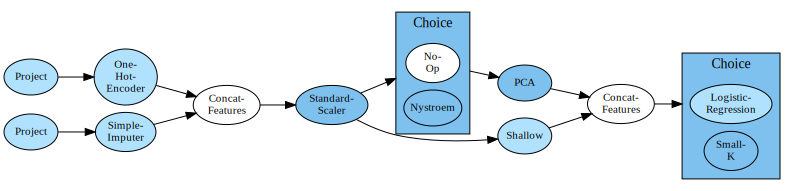

In [18]:
optimizable = data_prep >> est
optimizable.visualize()

## CASH Optimization via `auto_configure`

In [19]:
from lale.lib.lale import Hyperopt

In [20]:
best_pipeline = optimizable.auto_configure(
    train_X, train_y,
    Hyperopt,
    max_evals=15,
    max_eval_time=30,
    verbose=False,
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:38<00:00,  2.56s/trial, best loss: -0.7432835820895523]
1 out of 15 trials failed, call summary() for details.
Run with verbose=True to see per-trial exceptions.


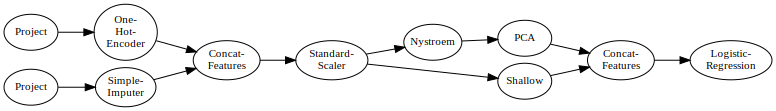

In [21]:
best_pipeline.visualize()

# Refinement

- `remove_last()`: Just remove final estimator and get the prefix of the pipeline
- `freeze_trained()`: Freeze a pre-trained and pre-tuned (sub-)pipeline 
  - frozen hyperparameters and model parameters
- `freeze_trainable()`: Freeze the hyperparameters of a pre-tuned (sub-)pipeline
  - frozen hyperparameters

In [22]:
pre_trained_prefix = best_pipeline.freeze_trained().remove_last()
pre_tuned_prefix = best_pipeline.freeze_trainable().remove_last()
prefix = best_pipeline.remove_last()

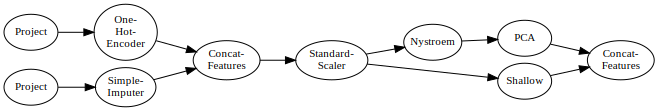

In [23]:
pre_trained_prefix.visualize()

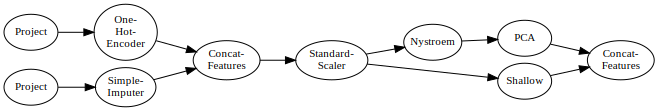

In [24]:
pre_tuned_prefix.visualize()

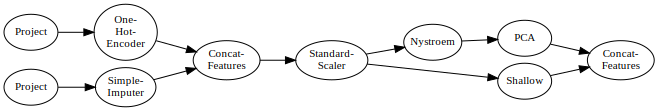

In [25]:
prefix.visualize()

In [26]:
from lale.lib.sklearn import LogisticRegression as LR
from lale.lib.lale import Hyperopt

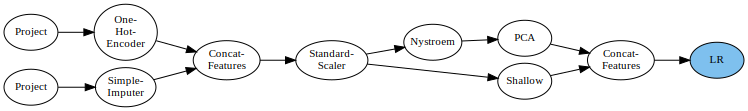

In [27]:
p1 = pre_trained_prefix >> LR
p1.visualize()
hpo1 = Hyperopt(estimator=p1, max_evals=15)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:17<00:00,  1.16s/trial, best loss: -0.7567164179104477]


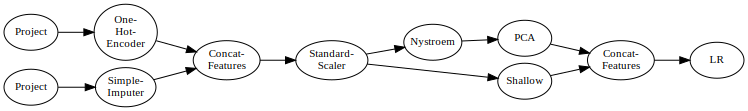

CPU times: user 1min 10s, sys: 54.9 s, total: 2min 5s
Wall time: 18.5 s


In [28]:
%%time
hpo1_trained = hpo1.fit(train_X, train_y)
best_p1 = hpo1_trained.get_pipeline()
best_p1.visualize()

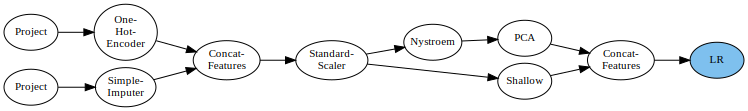

In [29]:
p2 = pre_tuned_prefix >> LR
p2.visualize()
hpo2 = Hyperopt(estimator=p2, max_evals=15)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:17<00:00,  1.18s/trial, best loss: -0.753731343283582]


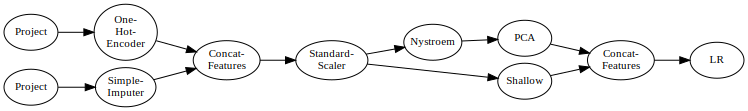

CPU times: user 1min 12s, sys: 55.3 s, total: 2min 7s
Wall time: 18.7 s


In [30]:
%%time
hpo2_trained = hpo2.fit(train_X, train_y)
best_p2 = hpo2_trained.get_pipeline()
best_p2.visualize()

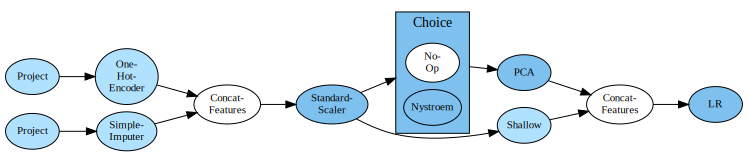

In [31]:
p4 = data_prep >> LR
p4.visualize()
hpo4 = Hyperopt(estimator=p4, max_evals=15, max_eval_time=30)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:06<00:00,  4.47s/trial, best loss: -0.744776119402985]
1 out of 15 trials failed, call summary() for details.
Run with verbose=True to see per-trial exceptions.


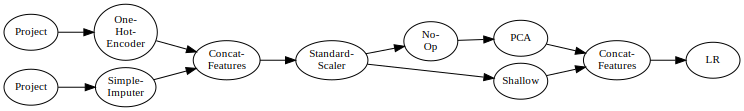

CPU times: user 4.82 s, sys: 1.89 s, total: 6.71 s
Wall time: 1min 8s


In [32]:
%%time
hpo4_trained = hpo4.fit(train_X, train_y)
best_p4 = hpo4_trained.get_pipeline()
best_p4.visualize()